In [85]:
import numpy as np # linear algebra
import pandas as pd # data processing
import re #pattern searching in a string
import plotly.express as px
import plotly as py
import matplotlib.pyplot as plt 
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style='darkgrid')
import warnings
warnings.filterwarnings("ignore")

Importing 3 Year Men's Apparel Data for 2020 - 2022

In [86]:
df20 = pd.read_csv("../prevention_analytics_pyspark/DataSet/transactions/data_2020.csv", parse_dates=['transaction_date'])
df21 = pd.read_csv("../prevention_analytics_pyspark/DataSet/transactions/data_2021.csv", parse_dates=['transaction_date'])
df22 = pd.read_csv("../prevention_analytics_pyspark/DataSet/transactions/data_2022.csv", parse_dates=['transaction_date'])

In [87]:
df = pd.concat([df20,df21,df22],axis=0)
print(df.shape)

(5395724, 12)


Total Record Size is ~ 5.4 million and Wrangle, prepare, cleanse the data

In [88]:
def find_nan(df):
    columns = df.columns
    col_values = df.isna().sum().values
    temp = pd.DataFrame(data=col_values,index=columns,columns=['missing_count'])
    temp['percent_missing'] = np.round((temp['missing_count'] / df.shape[0]) *100 ,2)
    return temp

find_nan(df)

,missing_count,percent_missing
user_id,0,0.00
bill_id,0,0.00
line_item_amount,0,0.00
bill_discount,0,0.00
transaction_date,0,0.00
description,14,0.00
inventory_category,640313,11.87
colour,15344,0.28
size,15344,0.28
zone_name,0,0.00


In [89]:
df.description = df.description.fillna(df.inventory_category)
df.description = df.description.fillna("Misc")

Defining the product code

In [90]:
def get_product(txt,pattern):
    if isinstance(txt, str):

        #search and check if split word exists
        searched_word = re.search(pattern, txt)
        
        #word exists
        if searched_word:
            splitted_string = re.split(pattern, txt)[0]
            # check if empty list is returned->when there is only pattern available in 'txt'
            if splitted_string == '':
                return 'Misc'
            else:
                return splitted_string.strip()
            
        #split word not exists(but the product name can still be present , so we'll need the entire string)
        else:
            return txt
        
    # any other value found other than string datatype
    else:
        return 'Misc'
    
df['desc_copy'] = df['description'].copy()
df['desc_copy'] = df['desc_copy'].fillna('Misc')

#for patterns starting with IT,CORE-, A16-,A17-,S16-,S18-,TBA07SD7890(LENGTH=11)
df[['product']] = df[['desc_copy']].applymap(lambda row:get_product(row,pattern=r'IT[A-Z0-9]+|CORE-|\b[A-Z]\d{2}-|\b[A-Z0-9]{11}\b')) 

#product names are acronyms are their lengths are not greater than 2.
df[['product']] = df[['product']].applymap(lambda row: 'Misc' if len(row.split())>=2 else row)

In [91]:
df['ic_copy'] = df['inventory_category'].copy()
df['ic_copy'] = df['ic_copy'].fillna('Misc')
df[['ic_copy']] = df[['ic_copy']].applymap(lambda row: re.sub(r'na','',row,flags=re.IGNORECASE))

df['colour'] = df['colour'].fillna('Misc')
df['colour'] = df['colour'].str.replace('NOT-CAPTURED','Misc')

df['size'] = df['size'].fillna('Misc')
df['size'] = df['size'].str.replace('NOT-CAPTURED','Misc')

Getting unique colors

In [92]:
## IDENTIFYING COLOURS
all_colours = df['colour'].value_counts().index.tolist()
pattern = r'\b(?:' + '|'.join(re.escape(color)  for color in all_colours if isinstance(color,str)) + r')\b'

def find(txt,pattern):
    x = re.findall(pattern, txt,flags=re.IGNORECASE)
    if x==[]:
        return ('Misc')
    return ' '.join(x)

print('Unique colours count before:',len(df['colour'].unique()))

unknown_colours_bef = df[df['colour']=='Misc'].shape[0]
df.loc[(df['colour']=='Misc'),'colour'] = df.loc[(df['colour']=='Misc'),'ic_copy'].map(lambda row: find(row,pattern))
unknown_colours_after = df[df['colour']=='Misc'].shape[0]
print('Colours found: ',unknown_colours_bef - unknown_colours_after)

print('Unique colours count after:',len(df['colour'].unique()))

Unique colours count before: 344
Colours found:  2259362
Unique colours count after: 390


Getting Size for each product

In [93]:
## IDENTIFYING SIZE
all_size = df['size'].unique().tolist()
pattern = r'\b(?:' + '|'.join(re.escape(size) for size in all_size if isinstance(size,str)) + r')\b'

print('Unique size count before:',len(df['size'].unique()))

unknown_size_bef = df[df['size']=='Misc'].shape[0]
df.loc[(df['size']=='Misc'),'size'] = df.loc[(df['size']=='Misc'),'ic_copy'].map(lambda row: find(row,pattern))
df.loc[(df['size']=='Misc'),'size'] = df.loc[(df['size']=='Misc'),'ic_copy'].map(lambda row: find(row,r'\d*x\d*x\d*|\d*mm|\d*cm|\d*m'))
unknown_size_after = df[df['size']=='Misc'].shape[0]
print('Sizes found: ',unknown_size_bef - unknown_size_after)

print('Unique size count after:',len(df['size'].unique()))

Unique size count before: 52
Sizes found:  2567244
Unique size count after: 107


In [94]:
replace = {'TR':'MENS TROUSER',
'MSP':'MENS SPORTSCOAT',
'BSP':'MENS SPORTSCOAT',
'TWB': 'MENS TROUSER WITH BELT',
'JKT': 'MENS JACKET',
'SH':'MENS SHIRT',
'MSH':'MENS SHIRT',
'MTR':'MENS TROUSER WITH BELT',
'MBL':'MENS BELT',
'BLT':'MENS BELT',
'SR':'MENS SHORTS',
'MTS':'MENS T-SHIRT',
'TS':'MENS T-SHIRT',
'BSH':'BOYS SHIRT',
'SW':'MENS SWEATER',
'BDE':'BOYS DENIM',
'MFW':'MENS FOOTWEAR',
'FW':'MENS FOOTWEAR',
'BDNM':'BOYS DENIM',
'SX':'MENS SOCKS',
'MSO':'MENS SHORTS',
'SO':'MENS SHORTS',
'MDE':'MENS DENIM',
'BTS':'BOYS T-SHIRT',
'BSO':'BOYS SHORTS',
'MDNM':'MENS DENIM',
'BTR':'BOYS TROUSER',
'MSW':'MENS SWEATER',
'SCKS':'MENS SOCKS',
'MSX':'MENS SOCKS',
'BSW':'BOYS SWEATER',
'MJKT':'MENS JACKET',
'MJA':'MENS JACKET',
'BJKT':'BOYS JACKET',
'BJO':'BOYS Jogger',
'MSC':'MENS JACKET',
'BS':'BOYS SHIRT',
'MWL':'Mens Wallet - Sportswear',
'BJA':'BOYS JACKET',
'BSR':'BOYS SHORTS',
'MDN':'MENS Denim Trouser',
'BDN':'Boys Denim Trouser - Jeanswear',
'KT':'MENS KNIT TROUSER',
'MJGR':'MENS JOGGER',
'TBG':'Trolley Bag',
'CBG':'CARRY BAG',
'MTIE':'MALE TIE',
'MJO':'MENS JOGGER',
'MWC':'MENS BANDI'}

df['inventory_category'] = df['product'].map(lambda x: replace[x] if x in replace.keys() else x)

In [95]:
find_nan(df)

,missing_count,percent_missing
user_id,0,0.0
bill_id,0,0.0
line_item_amount,0,0.0
bill_discount,0,0.0
transaction_date,0,0.0
description,0,0.0
inventory_category,0,0.0
colour,0,0.0
size,0,0.0
zone_name,0,0.0


In [96]:
# extract weekday and month from transaction date
df['month'] = df['transaction_date'].dt.month_name().map({'January':1, 'February':2,'March':3, 'April':4, 'May':5,  'June':6, 'July':7, 'August':8, 'September':9, 'October':10, 'November':11, 'December':12})
df['weekday'] = df['transaction_date'].dt.day_name().map({'Monday':1, 'Tuesday':2,'Wednesday':3, 'Thursday':4, 'Friday':5,  'Saturday':6, 'Sunday':7})
df['zone_name'] = df['zone_name'].map({'East':1, 'South':2, 'North':3, 'West':4, 'ROOT':5, 'Central':6}).astype(int)
df.sample(2)

,user_id,bill_id,line_item_amount,bill_discount,transaction_date,description,inventory_category,colour,size,zone_name,store_name,year,desc_copy,product,ic_copy,month,weekday
1198069,452731212,640372730,249.0,0.0,2021-08-13,TBG ITPTB00008 NA NA Brown (46x23x26),Trolley Bag,Brown,46x23x26,3,North_7289,2021,TBG ITPTB00008 NA NA Brown (46x23x26),TBG,TBG ITPTB00008 Brown (46x23x26),8,5
1482601,500150657,671336513,1499.0,0.0,2021-11-29,MTS ITMTS01073 Regular SS Indigo XL,MENS T-SHIRT,Indigo,XL,2,South_7281,2021,MTS ITMTS01073 Regular SS Indigo XL,MTS,MTS ITMTS01073 Regular SS Indigo XL,11,1


In [97]:
from datetime import datetime
df["transaction_date"] = df["transaction_date"].dt.date

In [98]:
import datetime as dt
snapshot_date = max(df.transaction_date) + dt.timedelta(days=1)

RFM Analysis Begins : 
1. Reading data and preprocessing
2. 
Create Recency Frequency Monetary (RFM) tabl
3. 
Model - Clustering with K-means algorim
4. m
Interpret the ults

RFM is abasic customer segmentation algorithm based on their purchasing behaviour. The behaviour is identified by using only three customer data points:

Recency: the recency of purchase/ How many days ago was their last purchase?
Frequency: the frequency of purchases/ total number of purchases/How many times has the customer purchased from our store?
Monetary: the mean monetary value of each purchase/the amount they have spent/How much has this customer spent? Again limit to last two years – or take all time
The RFM Analysis will help the businesses to segment their customer base into different homogenous groups so that they can engage with each group with different targeted marketing strategies. Sometime RMF is also used to identify the High-Value Customers (HVCs).ult

In [99]:
# RFM table
# Aggregate data by each customer
rfm = df.groupby('user_id').agg({'transaction_date': lambda x: (snapshot_date - x.max()).days, 'bill_id': lambda x: len(x.unique()), 'line_item_amount': lambda x: x.sum(), 'bill_discount': lambda x: x.sum(), 'product': lambda x: x.count()}).reset_index()
rfm['transaction_date'] = rfm['transaction_date'].astype(int)

# Rename columns
rfm.rename(columns={'transaction_date': 'Recency', 
                         'bill_id': 'Frequency', 
                         'line_item_amount': 'MonetaryValue','bill_discount':'DiscountValue', 'product':'Product'}, inplace=True)

In [100]:
# Rename columns
rfm.rename(columns={'transaction_date': 'Recency', 
                         'bill_id': 'Frequency', 
                         'line_item_amount': 'MonetaryValue','bill_discount':'DiscountValue', 'product':'Product'}, inplace=True)

We will utilize variables that use box-cox transformations. Except for the MonetaryValue and DiscountValue variable because the variable includes negative values. To handle this variable, we can use cubic root transformation to the data.

In [101]:
# Set the Numbers
from scipy import stats
customers_fix = pd.DataFrame()
customers_fix["Recency"] = stats.boxcox(rfm['Recency'])[0]
customers_fix["Frequency"] = stats.boxcox(rfm['Frequency'])[0]
customers_fix["MonetaryValue"] = pd.Series(np.cbrt(rfm['MonetaryValue'])).values
customers_fix["DiscountValue"]  = pd.Series(np.cbrt(rfm['DiscountValue'])).values
customers_fix["Product"] = stats.boxcox(rfm['Product'])[0]
customers_fix.tail()

,Recency,Frequency,MonetaryValue,DiscountValue,Product
643776,20.218111,0.0,17.322563,18.978732,1.167247
643777,20.065915,0.0,20.405875,29.782875,1.437462
643778,22.356589,0.0,20.949995,19.574338,1.319416
643779,22.176344,0.0,19.125667,19.309788,1.167247
643780,18.121678,0.0,17.322560,25.194221,1.167247


Normalization: we can use StandardScaler object from scikit-learn library

In [102]:
# Import library
from sklearn.preprocessing import StandardScaler
# Initialize the Object
scaler = StandardScaler()
# Fit and Transform The Data
scaler.fit(customers_fix)
customers_normalized = scaler.transform(customers_fix)
# Assert that it has mean 0 and variance 1
print(customers_normalized.mean(axis = 0).round(2)) 
print(customers_normalized.std(axis = 0).round(2)) 

[-0. -0. -0.  0.  0.]
[1. 1. 1. 1. 1.]


To make segmentation from the data, we can use the K-Means algorithm to do this.

K-Means algorithm is an unsupervised learning algorithm that uses the geometrical principle to determine which cluster belongs to the data. By determine each centroid, we calculate the distance to each centroid. Each data belongs to a centroid if it has the smallest distance from the other. It repeats until the next total of the distance doesn’t have significant changes than before.

Determine the Optimal K
To make our clustering reach its maximum performance, we have to determine which hyperparameter fits to the data. To determine which hyperparameter is the best for our model and data, we can use the elbow method to decide.

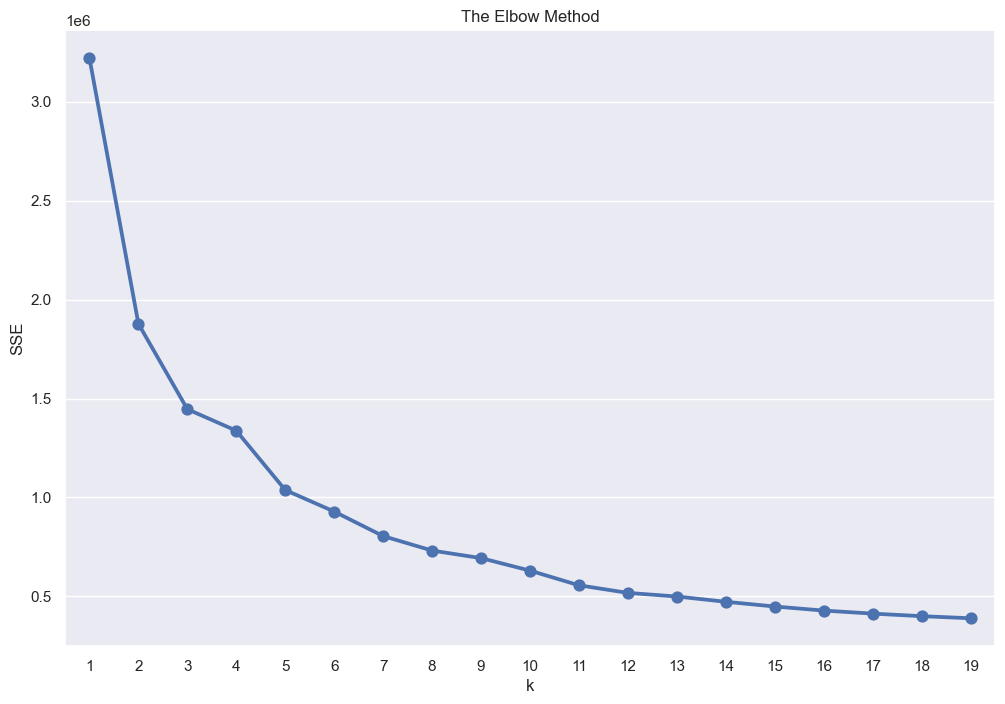

In [103]:
plt.figure(figsize=(12,8))

from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
K = range(1, 20)

distortions = []
inertias = []
mapping1 = {}
sse = {}
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(customers_normalized)
    
    distortions.append(sum(np.min(cdist(customers_normalized, kmeans.cluster_centers_,
                                        'euclidean'), axis=1)) / customers_normalized.shape[0])
    inertias.append(kmeans.inertia_)
 
    mapping1[k] = sum(np.min(cdist(customers_normalized, kmeans.cluster_centers_,
                                   'euclidean'), axis=1)) / customers_normalized.shape[0]
    
    sse[k] = kmeans.inertia_ # SSE to closest cluster centroid

plt.title('The Elbow Method')
plt.xlabel('k')
plt.ylabel('SSE')
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()

In [104]:
for key, val in mapping1.items():
    print(f'{key} : {val}')

1 : 1.9687570536901775
2 : 1.4974057057216759
3 : 1.343035693436815
4 : 1.3035518512525683
5 : 1.124292031114789
6 : 1.0668346238365012
7 : 0.971655217206543
8 : 0.9278547365207424
9 : 0.9120725009512864
10 : 0.875729161907317
11 : 0.8140837230465732
12 : 0.7712712720399666
13 : 0.7633685900529279
14 : 0.7294977304284013
15 : 0.7033931740252874
16 : 0.6739717868947299
17 : 0.6678313512636338
18 : 0.6595278665059036
19 : 0.6541796998541368


In [105]:
model = KMeans(n_clusters=3, random_state=42)
model.fit(customers_normalized)
model.labels_.shape

(643781,)

In [106]:
rfm["Cluster"] = model.labels_
rfm.head()

,user_id,Recency,Frequency,MonetaryValue,DiscountValue,Product,Cluster
0,50049,205,2,8805.0001,0.0,10,2
1,50174,386,5,24389.9998,2000.0,13,0
2,50511,300,3,16246.0021,0.0,11,2
3,50565,138,4,14108.0010,2478.0,15,0
4,53762,701,1,5397.9999,0.0,3,1


In [107]:
rfm.groupby('Cluster').agg({
    'Recency':'mean',
    'Frequency':'mean',
    'MonetaryValue':['mean', 'count'],'DiscountValue':['mean', 'count'] , 'Product':'count' }).round(1)

Recency Frequency MonetaryValue         DiscountValue         Product
           mean      mean          mean   count          mean   count   count
Cluster                                                                      
0         180.8       7.2       57460.5   45094       12267.0   45094   45094
1         447.3       1.0        4295.7  443695          47.4  443695  443695
2         327.1       2.8       17959.2  154992         118.9  154992  154992

In [108]:
model = KMeans(n_clusters=4, random_state=42)
model.fit(customers_normalized)
model.labels_.shape

rfm["Cluster"] = model.labels_
rfm.head()
rfm.groupby('Cluster').agg({
    'Recency':'mean',
    'Frequency':'mean',
    'MonetaryValue':['mean', 'count'], 'DiscountValue':['mean', 'count'], 'Product':'count'}).round(1)

Recency Frequency MonetaryValue         DiscountValue         Product
           mean      mean          mean   count          mean   count   count
Cluster                                                                      
0         247.4       3.5       17627.1   42730        3509.0   42730   42730
1         448.1       1.0        4289.6  442246          26.7  442246  442246
2         134.4      11.0      101120.9   19847       21694.4   19847   19847
3         330.2       2.8       18879.3  138958           2.1  138958  138958

In [109]:
df_normalized = pd.DataFrame(customers_normalized, columns=['Recency', 'Frequency', 'MonetaryValue', 'DiscountValue', 'Product'])
df_normalized['ID'] = rfm.index
df_normalized['Cluster'] = model.labels_
df_normalized.head()

,Recency,Frequency,MonetaryValue,DiscountValue,Product,ID,Cluster
0,-0.455966,1.256766,0.213462,-0.320487,0.922435,0,3
1,0.198714,1.747769,1.294505,1.904528,1.129113,1,0
2,-0.083692,1.587543,0.818963,-0.320487,0.999124,2,3
3,-0.783084,1.698200,0.668323,2.069286,1.236132,3,0
4,1.003805,-0.669328,-0.188821,-0.320487,-0.225835,4,1


In [110]:
df_nor_melt = pd.melt(df_normalized.reset_index(),
                      id_vars=['ID', 'Cluster'],
                      value_vars=['Recency','Frequency','MonetaryValue','DiscountValue','Product'],
                      var_name='Attribute',
                      value_name='Value')
df_nor_melt.head()

,ID,Cluster,Attribute,Value
0,0,3,Recency,-0.455966
1,1,0,Recency,0.198714
2,2,3,Recency,-0.083692
3,3,0,Recency,-0.783084
4,4,1,Recency,1.003805


In [111]:
fig3 = df_nor_melt.groupby('Cluster').agg({'ID': lambda x: len(x)}).reset_index()


# Rename columns
fig3.rename(columns={'ID': 'Count'}, inplace=True)
fig3['percent'] = (fig3['Count'] / fig3['Count'].sum()) * 100
fig3['percent'] = fig3['percent'].round(1)

fig3.head()

,Cluster,Count,percent
0,0,213650,6.6
1,1,2211230,68.7
2,2,99235,3.1
3,3,694790,21.6


In [112]:
colors=['#bad0af','#d5e0cf','#f1f1f1','#f1d4d4'] #color palette
import plotly.express as px

fig = px.treemap(fig3, path=['Cluster'],values='Count'
                 , width=800, height=400
                 ,title="Distribution of Cluster")

fig.update_layout(
    treemapcolorway = colors, #defines the colors in the treemap
    margin = dict(t=50, l=25, r=25, b=25))

fig.data[0].textinfo = 'label+text+value+percent root'
fig.show()

<Axes: xlabel='Attribute', ylabel='Value'>

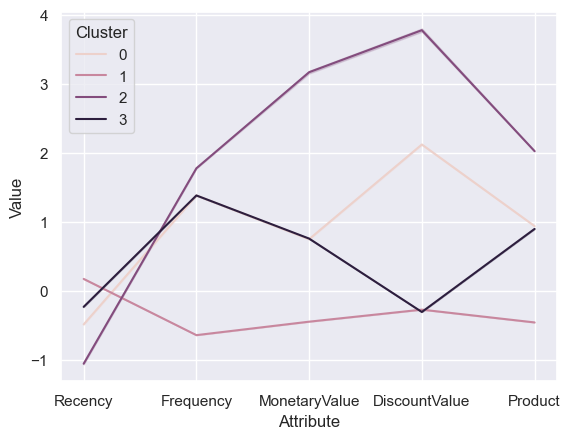

In [113]:
sns.lineplot(x='Attribute', y='Value', hue='Cluster', data=df_nor_melt)


Cluster# 0:	New customers- 	38%	 - Customers who transacted recently and have a lower purchase frequency, with a low amount of monetary spending.
Cluster# 1:	At risk customers - 31%	- Customer who made their last transaction a while ago and who made frequent and large purchases in the past.
Cluster# 2:	Lost customers/churned customers - 7% - Customers who made their last transaction a long time ago, and who have made few purchases. Therefore, it could be the cluster of Lost customer/churned customers.
Cluster# 3 : Loyal customers - 24%	 -Most frequent customers with the highest monetary spending amount and transact most recently


In [114]:
rfm.groupby('Cluster').agg({
    'Recency':'mean',
    'Frequency':'mean',
    'MonetaryValue':['mean', 'count'], 'DiscountValue':['mean','count'], 'Product':'count'}).round(1)

Recency Frequency MonetaryValue         DiscountValue         Product
           mean      mean          mean   count          mean   count   count
Cluster                                                                      
0         247.4       3.5       17627.1   42730        3509.0   42730   42730
1         448.1       1.0        4289.6  442246          26.7  442246  442246
2         134.4      11.0      101120.9   19847       21694.4   19847   19847
3         330.2       2.8       18879.3  138958           2.1  138958  138958

In [115]:
cluster_avg = rfm.groupby('Cluster').mean()
population_avg = rfm.mean()
relative_imp = cluster_avg / population_avg - 1
relative_imp

,Cluster,DiscountValue,Frequency,MonetaryValue,Product,Recency,user_id
Cluster,,,,,,,
0,NaN,2.812027,0.882733,0.558654,0.594793,-0.380863,-0.048005
1,NaN,-0.971009,-0.457838,-0.620698,-0.623431,0.121168,0.026799
2,NaN,22.567999,4.902152,7.941491,7.740311,-0.663617,-0.137660
3,NaN,-0.997714,0.485505,0.669375,0.695695,-0.173730,-0.050866


In [116]:
rfm_fig = rfm.copy()

#Remove the outlier for visualization
y1 = rfm_fig['Frequency']
size = rfm_fig.shape[0]
removed_outliers = y1.between(y1.quantile(.05), y1.quantile(.95))
print(str(y1[removed_outliers].size) + "/" + str(size) + " data points remain.") 
index_names = rfm_fig[~removed_outliers].index 
rfm_fig.drop(index_names, inplace=True)

#Remove the outlier for visualization
y2 = rfm_fig['Recency']
size = rfm_fig.shape[0]
removed_outliers = y2.between(y2.quantile(.05), y2.quantile(.95))
print(str(y2[removed_outliers].size) + "/" + str(size) + " data points remain.") 
index_names = rfm_fig[~removed_outliers].index 
rfm_fig.drop(index_names, inplace=True)

#Remove the outlier for visualization
y3 = rfm_fig['MonetaryValue']
size = rfm_fig.shape[0]
removed_outliers = y3.between(y3.quantile(.05), y3.quantile(.95))
print(str(y3[removed_outliers].size) + "/" + str(size) + " data points remain.") 
index_names = rfm_fig[~removed_outliers].index 
rfm_fig.drop(index_names, inplace=True)

#Remove the outlier for visualization
y4 = rfm_fig['DiscountValue']
size = rfm_fig.shape[0]
removed_outliers = y4.between(y4.quantile(.05), y4.quantile(.95))
print(str(y4[removed_outliers].size) + "/" + str(size) + " data points remain.") 
index_names = rfm_fig[~removed_outliers].index 
rfm_fig.drop(index_names, inplace=True)

#Remove the outlier for visualization
y5 = rfm_fig['Product']
size = rfm_fig.shape[0]
removed_outliers = y5.between(y5.quantile(.05), y5.quantile(.95))
print(str(y5[removed_outliers].size) + "/" + str(size) + " data points remain.") 
index_names = rfm_fig[~removed_outliers].index 
rfm_fig.drop(index_names, inplace=True)

615011/643781 data points remain.
553843/615011 data points remain.
498531/553843 data points remain.
474371/498531 data points remain.
452896/474371 data points remain.


In [117]:
cluster_avg = rfm[['Cluster','Recency','Frequency','MonetaryValue','DiscountValue', 'Product']].groupby(['Cluster']).mean()
population_avg = rfm[['Recency','Frequency','MonetaryValue','DiscountValue', 'Product']].head().mean()

In [118]:
cluster_avg

,Recency,Frequency,MonetaryValue,DiscountValue,Product
Cluster,,,,,
0,247.438451,3.514767,17627.098775,3508.986120,13.366440
1,448.075621,1.012131,4289.598313,26.686600,3.156139
2,134.435683,11.018391,101120.937695,21694.436822,73.255202
3,330.219412,2.773205,18879.262809,2.104714,14.212136


In [119]:
population_avg

Recency            346.00000
Frequency            3.00000
MonetaryValue    13789.40058
DiscountValue      895.60000
Product             10.40000
dtype: float64

In [120]:
relative_imp = cluster_avg / population_avg - 1
relative_imp.round(2)

,Recency,Frequency,MonetaryValue,DiscountValue,Product
Cluster,,,,,
0,-0.28,0.17,0.28,2.92,0.29
1,0.30,-0.66,-0.69,-0.97,-0.70
2,-0.61,2.67,6.33,23.22,6.04
3,-0.05,-0.08,0.37,-1.00,0.37


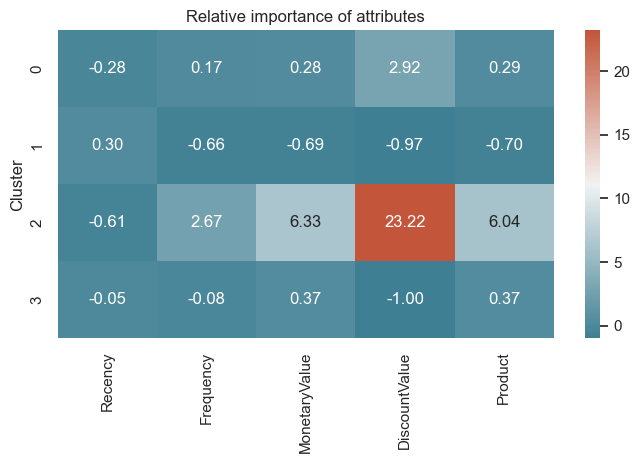

In [121]:
cmap = sns.diverging_palette(220, 20, as_cmap=True)
# Plot heatmap
plt.figure(figsize=(8, 4))
plt.title('Relative importance of attributes')
sns.heatmap(data=relative_imp, annot=True, fmt='.2f', cmap=cmap)
plt.show()

RFM Score:

The ranking of the individual RFM scores is done by dividing each of the RFM values into quartiles which creates four more or less equal buckets. We then rank each bucket from one to four; four being the best. Our summary table should now look something like this:

In [122]:
quantiles = rfm.quantile(q=[0.2,0.4,0.6,0.8])
quantiles = quantiles.to_dict()
    
def RScore(x,p,d):
    if x <= d[p][0.2]:
        return 5
    elif x <= d[p][0.4]:
        return 4
    elif x <= d[p][0.6]: 
        return 3
    elif x <= d[p][0.8]: 
        return 2
    else:
        return 1   
    
def FMScore(x,p,d):
    if x <= d[p][0.2]:
        return 1
    elif x <= d[p][0.4]:
        return 2
    elif x <= d[p][0.6]: 
        return 3
    elif x <= d[p][0.8]: 
        return 4
    else:
        return 5
    
rfm['R'] = rfm['Recency'].apply(RScore, args=('Recency',quantiles,))
rfm['F'] = rfm['Frequency'].apply(FMScore, args=('Frequency',quantiles,))
rfm['M'] = rfm['MonetaryValue'].apply(FMScore, args=('MonetaryValue',quantiles,))
rfm['G'] = rfm['DiscountValue'].apply(FMScore, args=('DiscountValue',quantiles,))
rfm['P'] = rfm['Product'].apply(RScore, args=('Product',quantiles,))

In [123]:
# Concat RFM quartile values to create RFM Segments
def join_rfm(x): return str(x['R']) + str(x['F']) + str(x['M']) + str(x['G']) + str(x['P']) 
rfm['RFM_Segment'] = rfm.apply(join_rfm, axis=1)
# Calculate RFM_Score
rfm['RFM_Score'] = rfm[['R','F','M']].sum(axis=1)

In [124]:
rfm['RFM_Segment'].unique()

array(['4.04.04.01.01.0', '3.05.05.05.01.0', '3.05.05.01.01.0',
       '4.05.05.05.01.0', '2.01.03.01.04.0', '5.05.04.01.02.0',
       '5.05.05.05.01.0', '5.04.05.05.01.0', '2.04.04.01.02.0',
       '4.05.04.01.02.0', '3.01.02.01.05.0', '3.04.05.01.01.0',
       '5.04.04.05.01.0', '3.05.05.01.02.0', '4.05.05.01.01.0',
       '1.01.01.01.04.0', '5.04.04.01.01.0', '1.01.03.01.03.0',
       '1.05.05.05.01.0', '1.01.03.01.02.0', '3.01.03.01.02.0',
       '3.01.01.01.05.0', '1.01.04.01.03.0', '1.01.01.01.05.0',
       '5.04.05.05.02.0', '5.01.03.05.04.0', '4.04.03.01.04.0',
       '4.01.03.01.03.0', '2.01.01.01.05.0', '3.01.04.01.02.0',
       '5.05.05.01.01.0', '1.04.03.01.02.0', '4.01.02.01.05.0',
       '2.04.04.01.03.0', '4.01.03.01.04.0', '5.04.04.01.02.0',
       '1.01.03.01.04.0', '5.04.05.01.02.0', '2.05.05.01.01.0',
       '1.01.02.01.04.0', '5.04.05.01.01.0', '3.04.04.01.03.0',
       '3.05.04.01.02.0', '2.01.04.01.03.0', '3.01.03.01.05.0',
       '5.04.01.05.05.0', '5.04.03.05.03

After calculations on the RFM data we can create customer segments that are actionable and easy to understand — like the ones below:

1. Champions: Bought recently, buy often and spend the most
2. Loyal customers: Buy on a regular basis. Responsive to promotions.
3. Potential loyalist: Recent customers with average frequency.
4. Recent customers: Bought most recently, but not often.
5. Promising: Recent shoppers, but haven’t spent much.
6. Needs attention: Above average recency, frequency and monetary values. May not have bought very recently though.
7. About to sleep: Below average recency and frequency. Will lose them if not reactivated.
8. At risk: Some time since they’ve purchased. Need to bring them back!
9. Can’t lose them: Used to purchase frequently but haven’t returned for a long time.
10. Hibernating: Last purchase was long back and low number of orders. May be lost.

In [125]:
# Create human friendly RFM labels
segt_map = {
    
    r'[1-2][1-2]': 'Hibernating',
    r'[1-2][3-4]': 'At risk', 
    r'[1-2]5': 'Can\'t lose them',
    r'3[1-2]': 'About to sleep',
    r'33': 'Need attention',
    r'[3-4][4-5]': 'Loyal customers',
    r'41': 'Promising',
    r'51': 'Price Sensitive',
    r'[4-5][2-3]': 'Potential loyalists',
    r'5[4-5]': 'Champions'
}
#rfm['Segment'] = rfm['R'].map(str) + rfm['F'].map(str)+ rfm['M'].map(str)
rfm['Segment'] = rfm['F'].map(str) + rfm['M'].map(str)
rfm['Segment'] = rfm['Segment'].replace(segt_map, regex=True)
# Create some human friendly labels for the scores
rfm.loc[(rfm['F']<=1),'Score'] = 'No Score'
rfm.loc[(rfm['RFM_Score']<4),'Score'] = 'Green'
rfm.loc[(rfm['RFM_Score']>=4),'Score'] = 'Bronze' 
rfm.loc[(rfm['RFM_Score']>8) ,'Score'] = 'Silver' 
rfm.loc[(rfm['RFM_Score']>12) ,'Score'] = 'Gold' 
rfm.loc[(rfm['RFM_Score']>=15) ,'Score'] = 'Platinum'
rfm.head(5)

,user_id,Recency,Frequency,MonetaryValue,DiscountValue,Product,Cluster,R,F,M,G,P,RFM_Segment,RFM_Score,Segment,Score
0,50049,205,2,8805.0001,0.0,10,3,4,4,4,1,1,4.04.04.01.01.0,12,Loyal customers,Silver
1,50174,386,5,24389.9998,2000.0,13,0,3,5,5,5,1,3.05.05.05.01.0,13,Champions,Gold
2,50511,300,3,16246.0021,0.0,11,3,3,5,5,1,1,3.05.05.01.01.0,13,Champions,Gold
3,50565,138,4,14108.0010,2478.0,15,0,4,5,5,5,1,4.05.05.05.01.0,14,Champions,Gold
4,53762,701,1,5397.9999,0.0,3,1,2,1,3,1,4,2.01.03.01.04.0,6,At risk,Bronze


In [126]:
fig1 = rfm.groupby(['Segment']).count().unstack().fillna(0)
fig2 = rfm.groupby(['Score']).count().unstack().fillna(0)

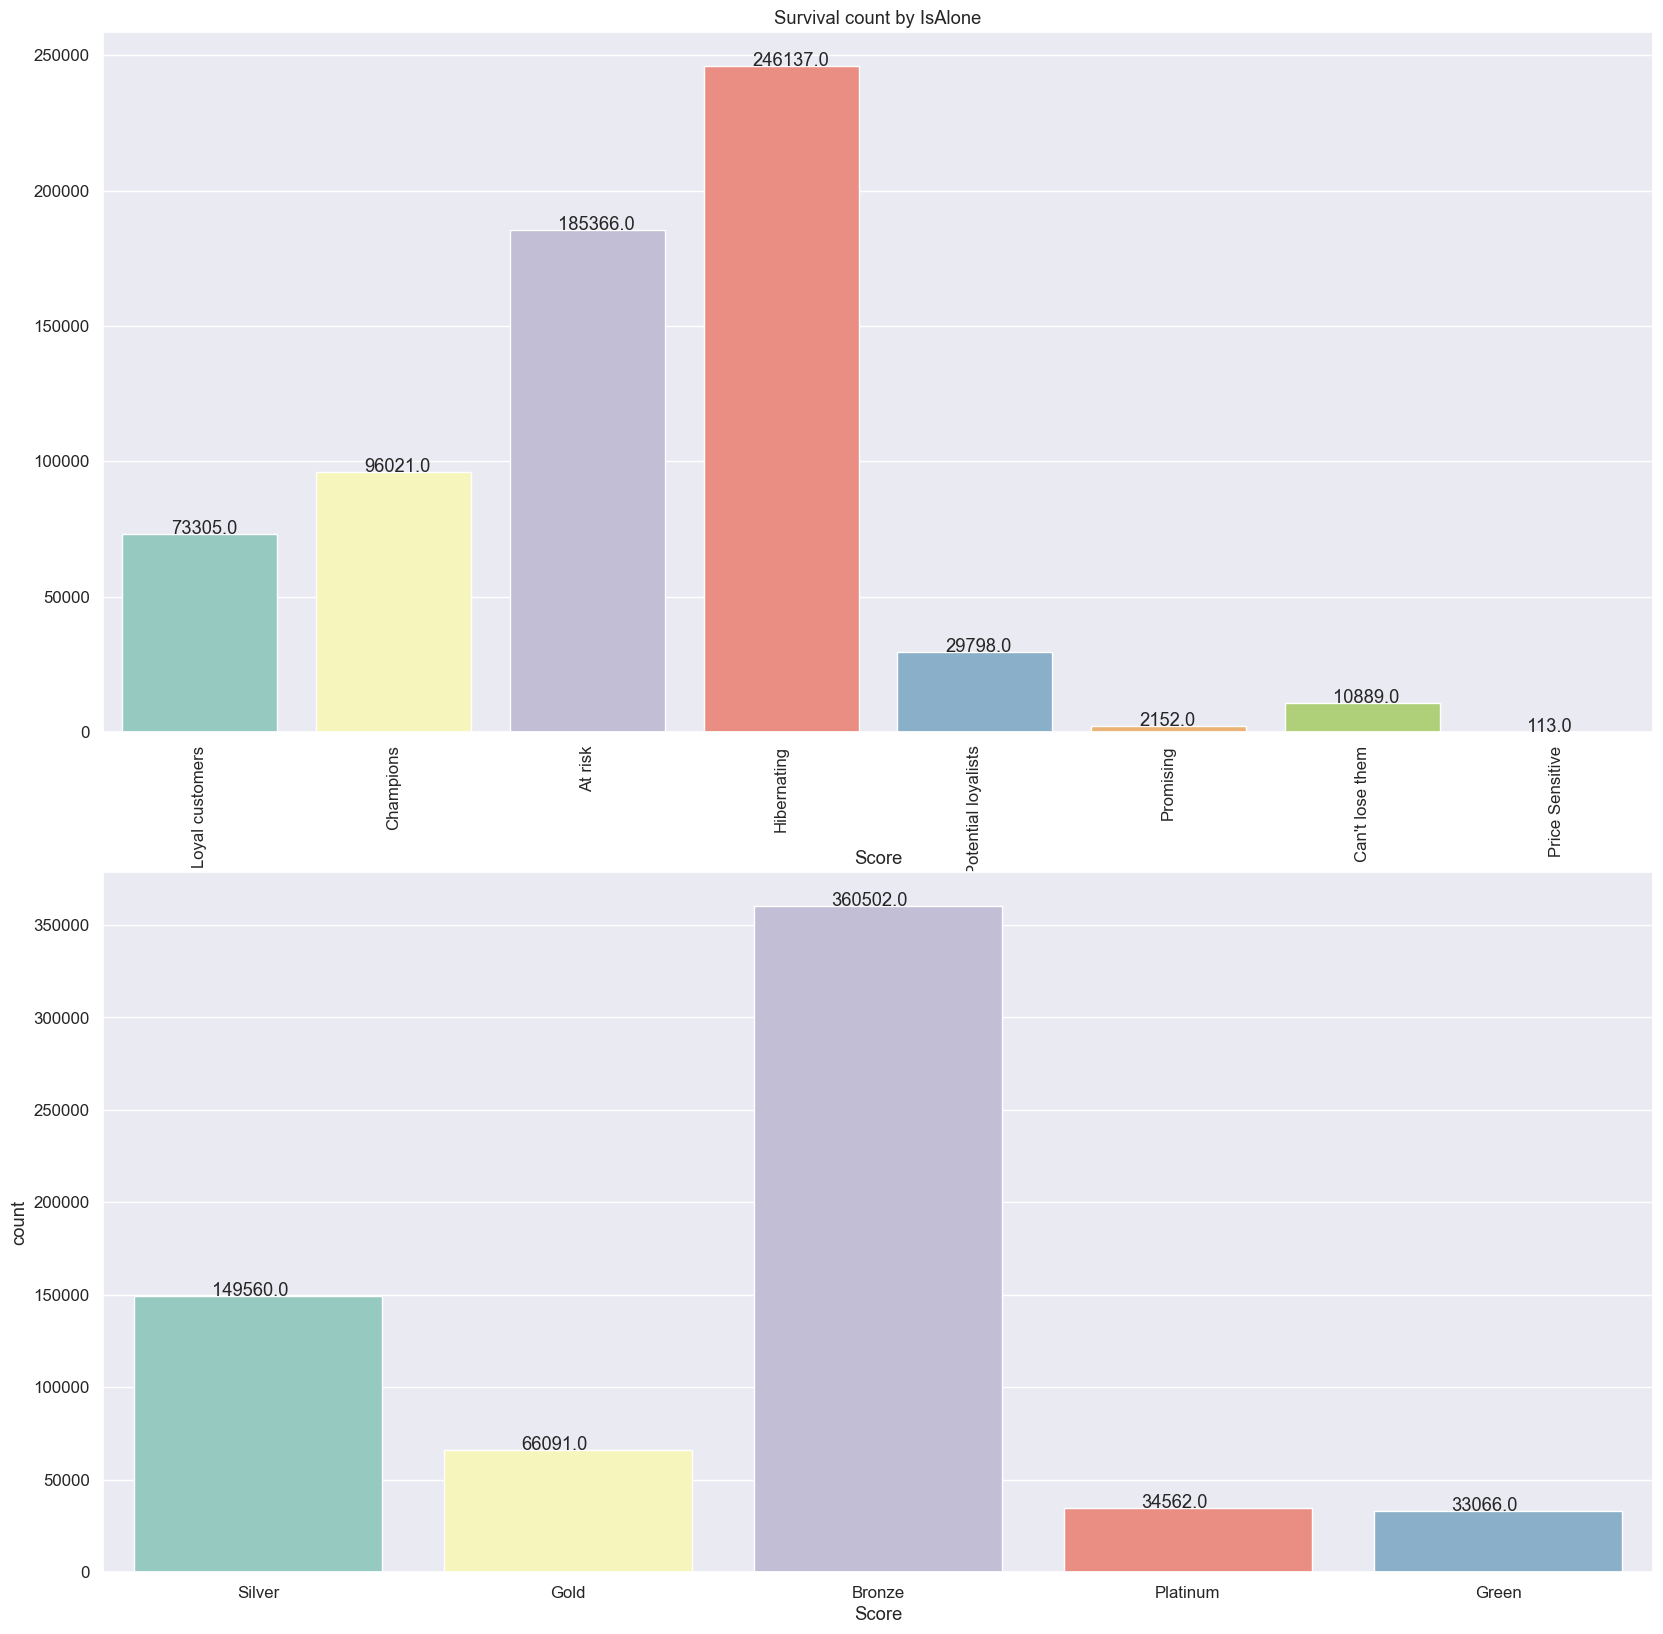

In [127]:
import matplotlib.pyplot as plt


sns.set(font_scale=1.1)

#Pie Chart
f,ax=plt.subplots(2,1,figsize=(20,20))
sns.countplot(x='Segment',data=rfm,ax=ax[0],palette="Set3")
ax[0].set_title('Segment')
ax[0].set_ylabel('')
ax[0].set_title('Survival count by IsAlone')
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=90)

#Bar chart - count
sns.countplot(x='Score',data=rfm,ax=ax[1],palette="Set3")
ax[1].set_title('Score')

for p in ax[0].patches:
    ax[0].annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.25, p.get_height()+20))

for p in ax[1].patches:
    ax[1].annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.25, p.get_height()+20))


plt.show()

In [128]:
# Aggregate data by each customer
fig3 = rfm.groupby('Segment').agg({'user_id': lambda x: len(x)}).reset_index()

# Rename columns
fig3.rename(columns={'user_id': 'Count'}, inplace=True)
fig3['percent'] = (fig3['Count'] / fig3['Count'].sum()) * 100
fig3['percent'] = fig3['percent'].round(1)

fig3.head()

,Segment,Count,percent
0,At risk,185366,28.8
1,Can't lose them,10889,1.7
2,Champions,96021,14.9
3,Hibernating,246137,38.2
4,Loyal customers,73305,11.4


In [129]:
colors=['#83af70','#9fbf8f','#bad0af','#d5e0cf','#f1f1f1','#f1d4d4','#f0b8b8','#ec9c9d'] #color palette
import plotly.express as px

fig = px.treemap(fig3, path=['Segment'],values='Count'
                 , width=800, height=400
                 ,title="RFM Segments")

fig.update_layout(
    treemapcolorway = colors, #defines the colors in the treemap
    margin = dict(t=50, l=25, r=25, b=25))

fig.data[0].textinfo = 'label+text+value+percent root'
fig.show()

In [130]:
# Aggregate data by each customer
fig4 = rfm.groupby('Score').agg({'user_id': lambda x: len(x)}).reset_index()


# Rename columns
fig4.rename(columns={'user_id': 'Count'}, inplace=True)
fig4['percent'] = (fig4['Count'] / fig4['Count'].sum()) * 100
fig4['percent'] = fig4['percent'].round(1)

fig4.head()

,Score,Count,percent
0,Bronze,360502,56.0
1,Gold,66091,10.3
2,Green,33066,5.1
3,Platinum,34562,5.4
4,Silver,149560,23.2


In [131]:
colors=['#bad0af','#d5e0cf','#f1f1f1','#f1d4d4'] #color palette
import plotly.express as px

fig = px.treemap(fig4, path=['Score'],values='Count'
                 , width=800, height=400
                 ,title="Treemap of RFM Score")

fig.update_layout(
    treemapcolorway = colors, #defines the colors in the treemap
    margin = dict(t=50, l=25, r=25, b=25))

fig.data[0].textinfo = 'label+text+value+percent root'
fig.show()

In [132]:
# Aggregate data by each customer
fig5 = rfm.groupby(['Cluster', 'Segment', 'Score']).agg({'user_id': lambda x: len(x)}).reset_index()

# Rename columns
fig5.rename(columns={'user_id': 'Count'}, inplace=True)
fig5['percent'] = (fig5['Count'] / fig5['Count'].sum()) * 100
fig5['percent'] = fig5['percent'].round(1)

fig5.head()
colors=['#bad0af','#d5e0cf','#f1f1f1','#f1d4d4'] #color palette
import plotly.express as px
fig = px.treemap(fig5, path=[px.Constant("Customer"), 'Cluster', 'Segment', 'Score'], values='Count'
                ,title="Treemap of Customer Segment")
fig.update_traces(root_color="lightgrey")
fig.update_layout(margin = dict(t=50, l=25, r=25, b=25))

fig.update_layout(
    treemapcolorway = colors, #defines the colors in the treemap
    margin = dict(t=50, l=25, r=25, b=25))

fig.data[0].textinfo = 'label+text+value+percent root'
fig.show()

In [133]:
# Aggregate data by each customer
rfm1 = rfm.groupby(['Cluster','Segment'],).agg({'user_id': lambda x: len(x)}).reset_index()

# Rename columns
rfm1.rename(columns={'user_id': 'Count'}, inplace=True)
rfm1['percent'] = (rfm1['Count'] / rfm1.groupby('Cluster')['Count'].transform('sum')) * 100
rfm1['percent'] = rfm1['percent'].round(1)

rfm1

,Cluster,Segment,Count,percent
0,0,At risk,2186,5.1
1,0,Can't lose them,74,0.2
2,0,Champions,25617,60.0
3,0,Hibernating,959,2.2
4,0,Loyal customers,9159,21.4
5,0,Potential loyalists,4499,10.5
6,0,Price Sensitive,28,0.1
7,0,Promising,208,0.5
8,1,At risk,183120,41.4
9,1,Can't lose them,8585,1.9


Perform Anomaly Detection using Deep Learning Auto Encoder Estimator

In [134]:
dfm2 = df.reset_index()
#dfm2.set_index("transaction_date", inplace=True)
#dfm2.index = pd.to_datetime(dfm2.index)
list_str_obj_cols = dfm2.columns[dfm2.dtypes == "object"].tolist()
for str_obj_col in list_str_obj_cols:
    dfm2[str_obj_col] = dfm2[str_obj_col].astype("category").cat.codes

In [135]:
import h2o
from h2o.estimators.deeplearning import H2OAutoEncoderEstimator
h2o.init()
#dfm2 = dfm2.reset_index()
dfm2 = dfm2[['user_id', 'bill_id', 'line_item_amount', 'bill_discount','product', 'colour','size','zone_name','transaction_date']]
data_from_df = h2o.H2OFrame(dfm2)
data_from_df_split = data_from_df.split_frame(ratios = [0.75], seed = 1234)
data_from_df_train = data_from_df_split[0] # using 75% for training
data_from_df_test = data_from_df_split[1]  # using the rest 20% for out-of-bag evaluation

## Set DeepLearning Grid Search Parameters
from h2o.estimators import H2ODeepLearningEstimator
from h2o.grid.grid_search import H2OGridSearch

# create hyperameter and search criteria lists (ranges are inclusive..exclusive))
dl_hyper_params_tune = {
    'activation' : ["Tanh","RectifierWithDropout","TanhWithDropout"],
    'hidden': [[2], [5], [10], [2, 2]],
    'input_dropout_ratio' : [0,0.05],
    'l1': [0, 1e-05, 2e-05, 3e-05, 4e-05, 5e-05, 6e-05, 7e-05, 8e-05, 9e-05, 1e-04],
    'l2': [0, 1e-05, 2e-05, 3e-05, 4e-05, 5e-05, 6e-05, 7e-05, 8e-05, 9e-05, 1e-04]}


random_search_criteria_tune = {'strategy': "RandomDiscrete",
                               'max_runtime_secs': 60, 
                               'seed' : 1234, # make it reproducible
                               'stopping_rounds' : 5, # stop grid search once the best models have similar AUC
                               'stopping_metric' : "MSE",
                               'stopping_tolerance': 1e-3
                              }

stopping_metric = "MSE"
stopping_tolerance = 1e-3
stopping_rounds = 10

## Deep Learning Model

dl_model = H2ODeepLearningEstimator(
    seed = 1234,
    ## here, use "more than enough" epochs - we have early stopping
    epochs=10000, 
    ## early stopping
    stopping_rounds = stopping_rounds,
    stopping_metric = stopping_metric,
    stopping_tolerance = stopping_tolerance,
    autoencoder = True,
    reproducible = True
)

## Run Deep Learning Grid Search
dl_grid = H2OGridSearch(dl_model, hyper_params = dl_hyper_params_tune,
                        grid_id = 'ae_grid',
                        search_criteria = random_search_criteria_tune)

dl_grid.train(x=dfm2, 
              ## early stopping based on timeout (no model should take more than 1 hour - modify as needed)
              max_runtime_secs = 3600, 
              training_frame = data_from_df_train,
              validation_frame = data_from_df_test
             )

## Run Deep Learning Grid Search
dl_grid = H2OGridSearch(dl_model, hyper_params = dl_hyper_params_tune,
                        grid_id = 'ae_grid',
                        search_criteria = random_search_criteria_tune)

dl_grid.train(x=dfm2, 
              ## early stopping based on timeout (no model should take more than 1 hour - modify as needed)
              max_runtime_secs = 3600, 
              training_frame = data_from_df_train,
              validation_frame = data_from_df_test
             )

dl_grid.get_grid("mse")
ae_model = h2o.get_model("ae_grid_model_3")
reconstruction_error = ae_model.anomaly(data_from_df)
anomalies_ae = data_from_df[reconstruction_error["Reconstruction.MSE"] > 0.03]
print("Number of Anomalies: " + str(anomalies_ae.nrow))
data_from_df["anomaly_ae"] = (reconstruction_error["Reconstruction.MSE"] > 0.03).ifelse("Yes", "No")
df_anm = data_from_df.as_data_frame()
#h2o.cluster().shutdown()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; OpenJDK 64-Bit Server VM (Zulu 8.78.0.19-CA-win64) (build 25.412-b08, mixed mode)
  Starting server from D:\vscode_projects\projects\DashBoard\dashboardenv\Lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\RUPESH~1.SIN\AppData\Local\Temp\tmpie82qvx1
  JVM stdout: C:\Users\RUPESH~1.SIN\AppData\Local\Temp\tmpie82qvx1\h2o_rupesh_singh_started_from_python.out
  JVM stderr: C:\Users\RUPESH~1.SIN\AppData\Local\Temp\tmpie82qvx1\h2o_rupesh_singh_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,05 secs
H2O_cluster_timezone:,Asia/Kolkata
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.2
H2O_cluster_version_age:,16 days
H2O_cluster_name:,H2O_from_python_rupesh_singh_7atbnq
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.485 Gb
H2O_cluster_total_cores:,0
H2O_cluster_allowed_cores:,0
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
deeplearning Grid Build progress: |██████████████████████████████████████████████| (done) 100%
deeplearning Grid Build progress: |██████████████████████████████████████████████| (done) 100%
Number of Anomalies: 27920


In [136]:
df_anm.transaction_date = df.reset_index().transaction_date

In [137]:
df_anm.transaction_date = df_anm.transaction_date.replace(np.nan,'2022-12-31')

In [138]:
rfm_a = df_anm.groupby(['product', 'zone_name']).agg({'anomaly_ae': lambda x: x.count() if (x=='Yes').all() else 0 }).reset_index()
# Rename columns
rfm_a.rename(columns={'anomaly_ae': 'nFraudItems'}, inplace=True)

Fraud Detection using Classification Model

In [139]:
from sklearn.model_selection import train_test_split
df_anm = df_anm.replace({'anomaly_ae': {'Yes': 1,  
                                'No': 0}}) 
df_anm.anomaly_ae = df_anm.anomaly_ae.astype(int)

df_anm['transaction_date'] =  pd.to_datetime(df_anm['transaction_date']).astype('int64')
X=df_anm.iloc[:,:-1] #selection feature set
Y=df_anm.iloc[:,-1:]

x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.3,random_state=1234) 

import xgboost as xgb
from sklearn.model_selection import GridSearchCV

# Define the hyperparameter grid
param_grid = {
    'max_depth': [7],
    'learning_rate': [0.01],
    'subsample': [0.7]
}

# Create the XGBoost model object
xgb_model = xgb.XGBClassifier()

# Create the GridSearchCV object
grid_search = GridSearchCV(xgb_model, param_grid, cv=5, scoring='accuracy')

# Fit the GridSearchCV object to the training data
grid_search.fit(x_train, y_train)

# Print the best set of hyperparameters and the corresponding score
print("Best set of hyperparameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

Best set of hyperparameters:  {'learning_rate': 0.01, 'max_depth': 7, 'subsample': 0.7}
Best score:  0.9996878481611404


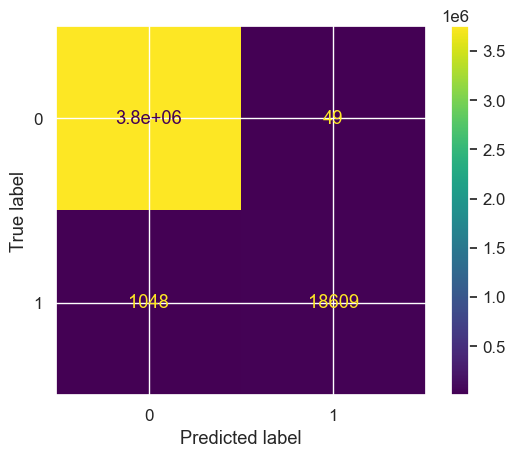

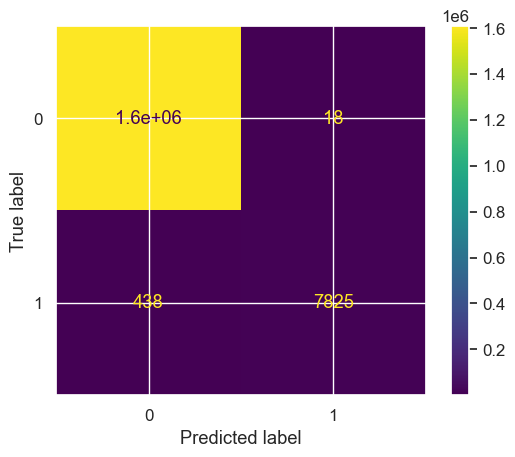

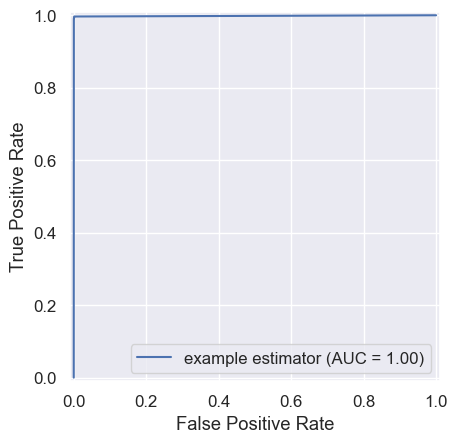

In [140]:
from sklearn.metrics import accuracy_score,f1_score,roc_auc_score,confusion_matrix,roc_curve, ConfusionMatrixDisplay,RocCurveDisplay,auc
#predictions - inputs to confusion matrix
train_predictions = grid_search.predict(x_train)
test_predictions = grid_search.predict(x_test)

#confusion matrices
cfm_train = confusion_matrix(y_train, train_predictions)
cfm_test = confusion_matrix(y_test, test_predictions)

disp = ConfusionMatrixDisplay(confusion_matrix=cfm_train
                             )
disp.plot()
plt.show()


disp = ConfusionMatrixDisplay(confusion_matrix=cfm_test)
disp.plot()
plt.show()

#accuracy scores
accs_train = accuracy_score(y_train, train_predictions)
accs_test = accuracy_score(y_test, test_predictions)


#F1 scores for each train/test label
f1s_train_p1 = f1_score(y_train, train_predictions, pos_label=1)
f1s_train_p0 = f1_score(y_train, train_predictions, pos_label=0)
f1s_test_p1 = f1_score(y_test, test_predictions, pos_label=1)
f1s_test_p0 = f1_score(y_test, test_predictions, pos_label=0)


#Area Under the Receiver Operating Characteristic Curve
test_ras = roc_auc_score(y_test, grid_search.predict_proba(x_test)[:,1])
fpr, tpr, thresholds = roc_curve(y_test, grid_search.predict_proba(x_test)[:,1])
roc_auc = auc(fpr, tpr)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                  estimator_name='example estimator')
display.plot()
plt.show()

In [141]:
df_anm['Fraud'] = grid_search.predict(df_anm[['user_id', 'bill_id', 'line_item_amount', 'bill_discount', 'product', 'colour', 'size', 'zone_name', 'transaction_date']])

In [142]:
rfm_an = df_anm.groupby('user_id').agg({'Fraud': lambda x: x.count() if(x==1).all() else 0}).reset_index()
# Rename columns
rfm_an.rename(columns={'Fraud': 'n'}, inplace=True)

In [143]:
#rfm['n'] = rfm_an['Fraud']
rfm['n'] = rfm_an['n']

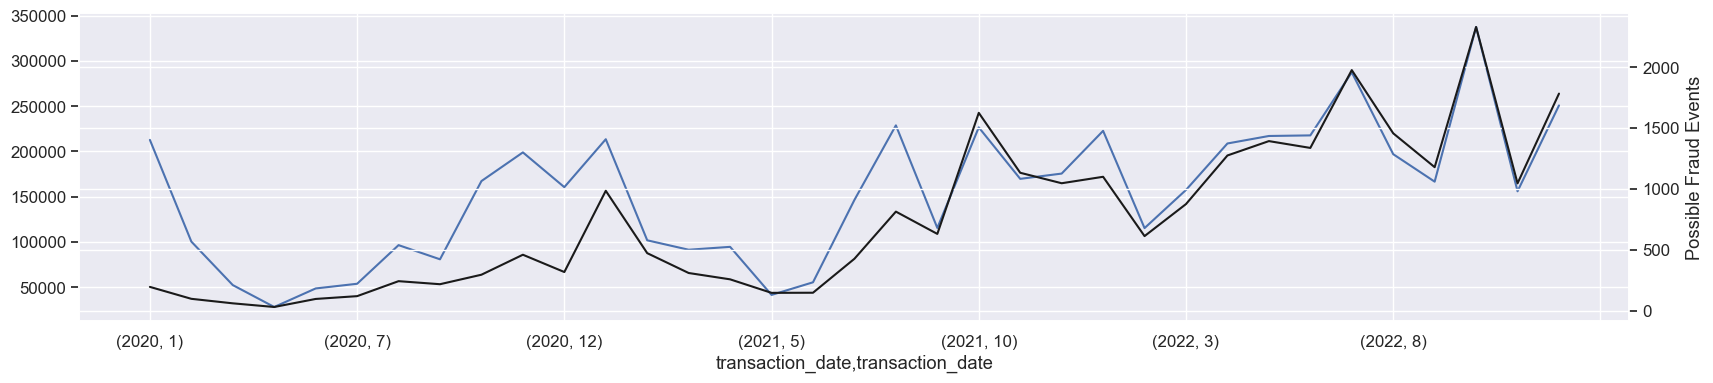

In [144]:
fig, axs = plt.subplots(figsize=(20, 4))
ax2 = axs.twinx()  
df_anm['transaction_date'] = pd.to_datetime(df_anm['transaction_date'])
df_anm.groupby([df_anm["transaction_date"].dt.year,df_anm["transaction_date"].dt.month])["product"].count().plot(
    kind='line', rot=0, ax=axs,  label = "line 1"
)
df_anm.groupby([df_anm["transaction_date"].dt.year,df_anm["transaction_date"].dt.month])["Fraud"].sum().plot(
    kind='line', rot=0, ax=ax2,  label = "line 2", color ='k'
)
plt.xlabel("Month")
plt.ylabel("Possible Fraud Events")

plt.show()

In [145]:
df_timeseries = df_anm.groupby(['product', 'transaction_date']).agg({'Fraud': lambda x: x.sum()}).reset_index()

In [146]:
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA
sf = StatsForecast(
    models = [AutoARIMA(season_length = 12)],
    freq = 'D'
)
df_timeseries.rename(columns={'product': 'unique_id','transaction_date': 'ds', 'Fraud':'y'}, inplace=True)
sf.fit(df_timeseries)
df_forecast = sf.predict(h=100, level=[90])
df_forecast = df_forecast.round()

In [147]:
#df_forecast[df_forecast.AutoARIMA >1].reset_index().unique_id.unique()

In [148]:
dfz_timeseries = df_anm.groupby(['zone_name', 'transaction_date']).agg({'Fraud': lambda x: x.sum()}).reset_index()
dfz_timeseries.rename(columns={'zone_name': 'unique_id','transaction_date': 'ds', 'Fraud':'y'}, inplace=True)

In [151]:
sf1 = StatsForecast(
    models = [AutoARIMA(season_length = 52)],
    freq = 'W'
)
sf1.fit(dfz_timeseries)
dfz_forecast = sf1.predict(h=4, level=[90])
dfz_forecast = dfz_forecast.round()

In [152]:
# Aggregate data by each customer
fig6 = rfm.groupby(['Cluster', 'Segment']).agg({'user_id': lambda x: x.count(), 'Product': lambda x: x.sum(), 'n': lambda x: x.sum()}).reset_index()

# Rename columns
fig6.rename(columns={'user_id': 'Count','Product' : 'tprod','n' : 'nsum'}, inplace=True)
fig6['percent'] = (fig6['nsum'] / fig6['tprod']) * 100
fig6['percent'] = fig6['percent'].round(1)

fig6.head()
colors=['#bad0af','#d5e0cf','#f1f1f1','#f1d4d4'] #color palette
import plotly.express as px
fig = px.treemap(fig6, path=[px.Constant("Fraud"), 'Cluster', 'Segment', 'tprod','nsum'], values='percent'
                ,title="Treemap of Customer Segment")
fig.update_traces(root_color="lightgrey")
fig.update_layout(margin = dict(t=50, l=25, r=25, b=25))

fig.update_layout(
    treemapcolorway = colors, #defines the colors in the treemap
    margin = dict(t=50, l=25, r=25, b=25))

fig.data[0].textinfo = 'label+text+value'
fig.show()

In [154]:
import dash
from dash.dependencies import Output
from dash.dependencies import Input
import plotly.express as px
import dash_bootstrap_components as dbc
import os
import pandas as pd
import random
from dash import Dash, html, dash_table, dcc, callback, Output, Input
import pandas as pd


# Initialize the app - incorporate css
external_stylesheets = ['https://codepen.io/chriddyp/pen/bWLwgP.css']
app = Dash(external_stylesheets=external_stylesheets)

# App layout
app.layout = [
    html.Div([
        html.H1('Fraud Events - Dashboard'),
        dcc.Tabs(id="tabs-example-graph", value='tab-0-example-graph', children=[
            dcc.Tab(label ='Segment', value = 'tab-0-example-graph'),
            dcc.Tab(label='Zone Wise', value='tab-1-example-graph'),
            dcc.Tab(label='Product Wise', value='tab-2-example-graph'),
        ]),
        html.Div(id='tabs-content-example-graph')
    ])
]
@callback(Output('tabs-content-example-graph', 'children'),
              Input('tabs-example-graph', 'value'))
def render_content(tab):
    if tab == 'tab-0-example-graph':
          return html.Div([html.H3('Total Fraud Activities by Segments'),
            
            dcc.Graph(figure=fig, id='fraud-treechart-segment')])
                           
    elif tab == 'tab-1-example-graph':
        return html.Div([html.H3('Fraud Activities Forecast by Zone'),

           dcc.Dropdown( id = 'dropdown',
                options = 
                    dfz_forecast.reset_index().unique_id.unique(),
                    value = dfz_forecast.reset_index().unique_id.unique()[0]),
            
            dcc.Graph(figure={}, id='fraud-chart-hist'),
            dcc.Graph(figure={}, id='fraud-chart-final')
          
    ])

    elif tab == 'tab-2-example-graph':
        return html.Div([html.H3('Fraud Activities Forecast by Products'),

           dcc.Dropdown( id = 'dropdown',
                options = 
                    df_forecast.reset_index().unique_id.unique(),
                    value = df_forecast.reset_index().unique_id.unique()[0]),
            
            dcc.Graph(figure={}, id='fraud-chart-hist'),
            dcc.Graph(figure={}, id='fraud-chart-final')
          
    ])

# Add controls to build the interaction
@callback(
    Output(component_id='fraud-chart-final', component_property='figure'),
    Input(component_id='dropdown', component_property='value')
)

def update_graph(dropdown_value):
  
    fig = px.line(df_forecast[df_forecast.index.isin([dropdown_value])], x='ds', y='AutoARIMA',labels={
                     "ds": "Timeline",
                     "AutoARIMA": "Fraud Events"}, title = "Forecasted Fraud Events")
    return fig

# Add controls to build the interaction
@callback(
    Output(component_id='fraud-chart-hist', component_property='figure'),
    Input(component_id='dropdown', component_property='value')
)

def update_hist(dropdown_value):
  
    fig = px.line(df_timeseries[df_timeseries.unique_id.isin([dropdown_value])], x='ds', y='y',labels={
                     "ds": "Timeline",
                     "y": "Fraud Events"}, title = "Historical Trends Fraud Events")
    return fig

# Run the app
if __name__ == '__main__':
    app.run(debug=False)